In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from typing import *
import numpy as np
import pandas as pd
from functools import partial
import math
from pathlib import Path
from collections import defaultdict
from prettytable import PrettyTable
from scipy.stats import ks_2samp

import torch
from torch import Tensor, nn
import torch.nn.functional as F

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Funcs

In [5]:
Path('../../mode_muon_tomography_scattering/data/validation/new/Fe_1cm_5GeV_normal.txt').stem.split('_')

['Fe', '1cm', '5GeV', 'normal']

In [6]:
warnings.filterwarnings('ignore')
def get_scatters(file:Path, n_muons:Optional[int]=None, n_ks_samples:Optional[int]=None,
                 mat_lookup:Dict[str,str]={'Al':'aluminium', 'Cu':'copper', 'Fe':'iron', 'U':'uranium'}) -> Dict[str,Any]:
    r'''
    file example Fe_1cm_5GeV_normal.txt
    '''
    
    # Init layer
    layer = PassiveLayer(lw=Tensor([1,1]), z=1, size=0.1)
    try: layer(1)
    except: pass
    
    # Get settings
    df = pd.read_csv(file)
    settings = file.stem.split('_')
    mat = mat_lookup[settings[0]]
    dz = float(settings[1][:settings[1].lower().find('cm')])/100
    mom = float(settings[2][:settings[2].lower().find('gev')])
    if settings[3] == 'normal':
        theta = 0.0
    elif settings[3] == 'ZenithAngle=pi4':
        theta = np.pi/4
    phi = 0
    if n_muons is None:
        n_muons = len(df) 
    else:
        raise ValueError(f'Unknown angle setting {settings[3]}')
    df = df.sample(n_muons, replace=n_muons > len(df))
    print(f'Making sims for {mat=}, {dz=}, {mom=}, {theta=}, {phi=}, {n_muons=}')
    if n_ks_samples is None: n_ks_samples=n_muons
    
    # Get sims
    xy_m_t_p = torch.ones(n_muons, 5)
    xy_m_t_p[:,2] = mom
    xy_m_t_p[:,3] = theta
    xy_m_t_p[:,4] = phi
    muons = MuonBatch(xy_m_t_p, init_z=1)
    x0 = torch.ones(len(muons)) * X0[mat]
    
    # prep data
    df['dx_muon'] = df.dx_muon/1000
    df['dy_muon'] = df.dy_muon/1000
    df['dx_vol'] = df.dx_muon*np.cos(muons.theta_x[0].item())
    df['dy_vol'] = df.dy_muon*np.cos(muons.theta_y[0].item())
    df['dtheta_vol'] = df.dtheta_x*torch.pi/180
    df['dphi_vol'] = df.dtheta_y*torch.pi/180
    df['dspace_vol'] = np.sqrt(np.square(df.dx_vol)+np.square(df.dy_vol))
    df['dangle_vol'] = np.sqrt(np.square(df.dtheta_vol)+np.square(df.dphi_vol))
        
    # New param model
    geant_scattering = layer._geant_scatter(x0=x0, deltaz=0.01, theta=muons.theta, theta_x=muons.theta_x, theta_y=muons.theta_y, mom=muons.mom)
    geant_scattering['dangle_vol'] = np.sqrt((geant_scattering['dtheta_vol']**2)+(geant_scattering['dphi_vol']**2))
    geant_scattering['dspace_vol'] = np.sqrt((geant_scattering['dx_vol']**2)+(geant_scattering['dy_vol']**2))
    
    # New PDG model
    pdg_scattering = layer._pdg_scatter(x0=x0, deltaz=0.01, theta=muons.theta, theta_x=muons.theta_x, theta_y=muons.theta_y, mom=muons.mom)
    pdg_scattering['dangle_vol'] = np.sqrt((pdg_scattering['dtheta_vol']**2)+(pdg_scattering['dphi_vol']**2))
    pdg_scattering['dspace_vol'] = np.sqrt((pdg_scattering['dx_vol']**2)+(pdg_scattering['dy_vol']**2))
    
    # Make plots and tests
    tests = defaultdict(lambda:defaultdict(dict))
    
    def get_ks(a, b) -> float:
        a = np.random.choice(a,size=min([n_ks_samples,len(a)]), replace=False)
        b = np.random.choice(b,size=min([n_ks_samples,len(b)]), replace=False)
        return ks_2samp(a, b).pvalue
    
    var = 'dangle_vol'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean_fdiff'] = np.abs(sim[var].mean()-df[var].mean())/df[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var],95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var] <= cut95], df.loc[df[var]<=cut95,var])
        cut68 = np.percentile(df[var],68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var] <= cut68], df.loc[df[var]<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
   
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label=f'Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([0, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-3, 1e4)
    plt.show()
    
    print(tab)
    
    var = 'dtheta_vol'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean'] = sim[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var].abs(),95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut95], df.loc[df[var].abs()<=cut95,var])
        cut68 = np.percentile(df[var].abs(),68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut68], df.loc[df[var].abs()<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
    
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label='Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([-cut99, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-3, 1e4)
    plt.show()
    
    print(tab)
    
    
    var = 'dphi_vol'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean'] = sim[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var].abs(),95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut95], df.loc[df[var].abs()<=cut95,var])
        cut68 = np.percentile(df[var].abs(),68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut68], df.loc[df[var].abs()<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
    
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label='Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([-cut99, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-3, 1e4)
    plt.show()
    
    print(tab)
    
    var = 'dspace_vol'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean_fdiff'] = np.abs(sim[var].mean()-df[var].mean())/df[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var],95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var] <= cut95], df.loc[df[var]<=cut95,var])
        cut68 = np.percentile(df[var],68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var] <= cut68], df.loc[df[var]<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
        
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label=f'Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([0, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-1, 1e6)
    plt.show()
    
    print(tab)
    
    var = 'dx_vol'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean'] = sim[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var].abs(),95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut95], df.loc[df[var].abs()<=cut95,var])
        cut68 = np.percentile(df[var].abs(),68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut68], df.loc[df[var].abs()<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
    
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label='Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([-cut99, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-1, 1e6)
    plt.show()
    
    print(tab)
    
    var = 'dy_vol'
    print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',geant_scattering)):
        tests[var][name]['mean'] = sim[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-df[var].std())/df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], df[var])
        cut95 = np.percentile(df[var].abs(),95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut95], df.loc[df[var].abs()<=cut95,var])
        cut68 = np.percentile(df[var].abs(),68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var].abs() <= cut68], df.loc[df[var].abs()<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
    
    sns.distplot(df[var], label='True GEANT')
    sns.distplot(geant_scattering[var], label='Param GEANT')
    sns.distplot(pdg_scattering[var], label='PDG')
    cut99 = np.percentile(df[var],99.9)
    plt.xlim([-cut99, cut99])
    plt.xlabel(var)
    plt.legend()
    plt.show()
    
    sns.distplot(df.loc[df[var].abs()>cut68, var].abs(), label='True GEANT')
    sns.distplot(geant_scattering[var][geant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
    sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
    plt.xlabel(f'|{var}|')
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-1, 1e6)
    plt.show()
    
    print(tab)
    
    return {'data':{'df':df, 'param_geant':geant_scattering, 'pdg':pdg_scattering}, 'tests':tests}

In [7]:
val_path = Path('../../mode_muon_tomography_scattering/data/validation/new/')

In [8]:
val_data = list(val_path.glob('*.txt'))

In [9]:
for i,p in enumerate(val_data): print(i,p)

0 ../../mode_muon_tomography_scattering/data/validation/new/Fe_1cm_5GeV_ZenithAngle=pi4.txt
1 ../../mode_muon_tomography_scattering/data/validation/new/Fe_1cm_50GeV_normal.txt
2 ../../mode_muon_tomography_scattering/data/validation/new/Al_1cm_5GeV_normal.txt
3 ../../mode_muon_tomography_scattering/data/validation/new/U_1cm_5GeV_normal.txt
4 ../../mode_muon_tomography_scattering/data/validation/new/Fe_1cm_5GeV_normal.txt
5 ../../mode_muon_tomography_scattering/data/validation/new/Fe_1cm_1GeV_normal.txt
6 ../../mode_muon_tomography_scattering/data/validation/new/Cu_1cm_5GeV_normal.txt


Making sims for mat='iron', dz=0.01, mom=5.0, theta=0.0, phi=0, n_muons=100000


 dangle_vol


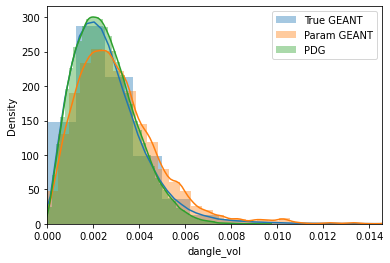

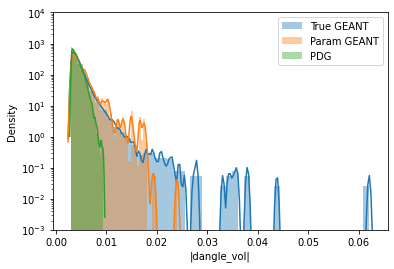

+-------------+----------------+----------------+-----------------------+-----------------------+-----------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p         |      bulk95_ks_p      |      bulk68_ks_p      |
+-------------+----------------+----------------+-----------------------+-----------------------+-----------------------+
|     pdg     | tensor(0.0466) | tensor(0.2285) | 1.363696417900441e-35 | 2.769061984654549e-12 | 7.781375974830233e-08 |
| param_geant | tensor(0.1713) | tensor(0.1583) |          0.0          |          0.0          |  4.21230861329751e-55 |
+-------------+----------------+----------------+-----------------------+-----------------------+-----------------------+


 dtheta_vol


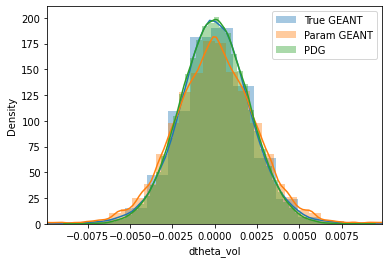

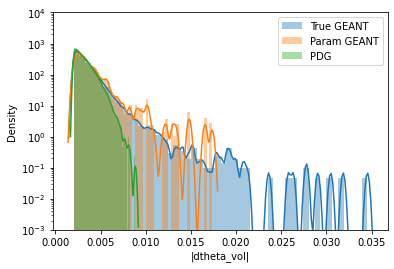

+-------------+---------------------+----------------+------------------------+------------------------+-----------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p          |      bulk95_ks_p       |      bulk68_ks_p      |
+-------------+---------------------+----------------+------------------------+------------------------+-----------------------+
|     pdg     | tensor(-2.8128e-06) | tensor(0.0995) | 0.00024375915861793817 |  0.008519754162718997  |  0.18751273728911066  |
| param_geant | tensor(-1.1591e-06) | tensor(0.1596) | 3.6308006409354605e-60 | 1.2195326832979562e-35 | 1.319044387669685e-07 |
+-------------+---------------------+----------------+------------------------+------------------------+-----------------------+


 dphi_vol


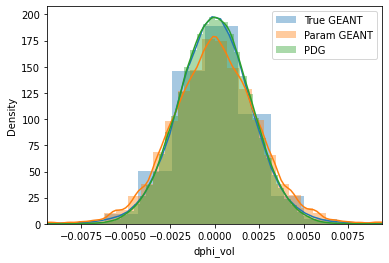

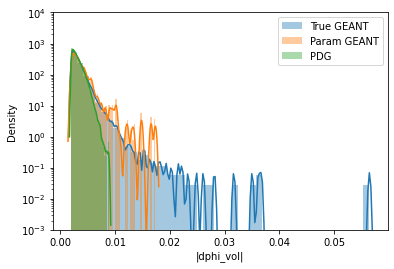

+-------------+---------------------+----------------+-----------------------+------------------------+-----------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p       |      bulk68_ks_p      |
+-------------+---------------------+----------------+-----------------------+------------------------+-----------------------+
|     pdg     | tensor(-1.0365e-06) | tensor(0.0931) | 0.0025105361693236934 |   0.0575042137666929   |  0.30249579660586756  |
| param_geant |  tensor(1.2614e-05) | tensor(0.1754) | 6.563289200876653e-69 | 2.6026934292293012e-34 | 2.069385546656957e-06 |
+-------------+---------------------+----------------+-----------------------+------------------------+-----------------------+


 dspace_vol


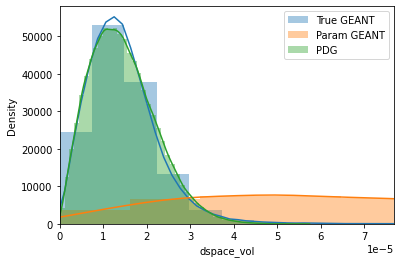

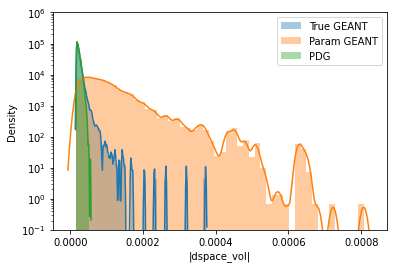

+-------------+----------------+----------------+------------------------+-----------------------+------------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p          |      bulk95_ks_p      |      bulk68_ks_p       |
+-------------+----------------+----------------+------------------------+-----------------------+------------------------+
|     pdg     | tensor(0.0063) | tensor(0.1401) | 1.0299825964882311e-19 | 9.564770411398698e-30 | 1.4440416102655356e-07 |
| param_geant | tensor(5.5456) | tensor(7.9374) |          0.0           |          0.0          | 2.7033273618647472e-77 |
+-------------+----------------+----------------+------------------------+-----------------------+------------------------+


 dx_vol


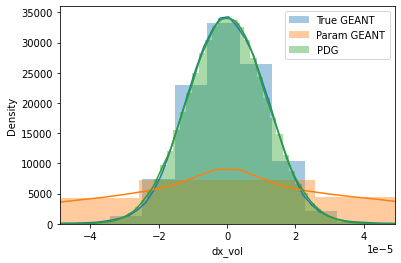

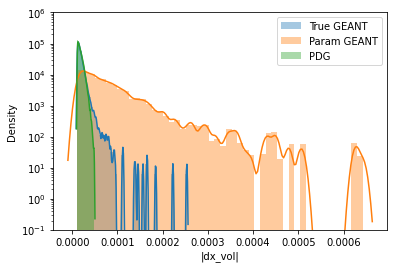

+-------------+---------------------+----------------+---------------------+-------------------------+------------------------+
|     Sim     |         mean        |   std_fdiff    |         ks_p        |       bulk95_ks_p       |      bulk68_ks_p       |
+-------------+---------------------+----------------+---------------------+-------------------------+------------------------+
|     pdg     | tensor(-1.8868e-08) | tensor(0.0395) | 0.06733861338421354 |   0.08272707568488236   |  0.22217722920388516   |
| param_geant |  tensor(2.8150e-07) | tensor(6.2674) |         0.0         | 1.6315848409558927e-167 | 6.567907717398233e-275 |
+-------------+---------------------+----------------+---------------------+-------------------------+------------------------+


 dy_vol


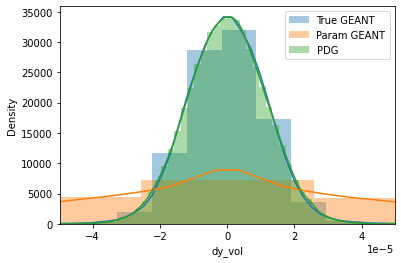

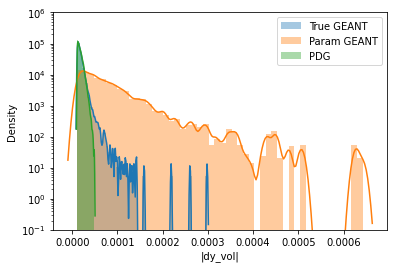

+-------------+---------------------+----------------+--------------------+-------------------------+------------------------+
|     Sim     |         mean        |   std_fdiff    |        ks_p        |       bulk95_ks_p       |      bulk68_ks_p       |
+-------------+---------------------+----------------+--------------------+-------------------------+------------------------+
|     pdg     | tensor(-6.2946e-09) | tensor(0.0405) | 0.0875556025612313 |   0.09956715593559229   |  0.30563799107520206   |
| param_geant |  tensor(1.8139e-07) | tensor(6.2480) |        0.0         | 5.3563396054433793e-166 | 3.205680672199385e-274 |
+-------------+---------------------+----------------+--------------------+-------------------------+------------------------+


In [10]:
results = get_scatters(val_data[4], n_ks_samples=None)

Making sims for mat='iron', dz=0.01, mom=5.0, theta=0.0, phi=0, n_muons=100000


 dangle_vol


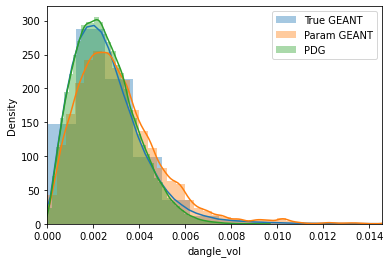

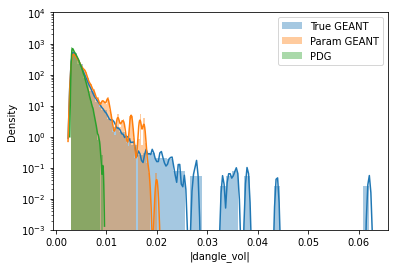

+-------------+----------------+----------------+------------------------+-----------------------+------------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p          |      bulk95_ks_p      |      bulk68_ks_p       |
+-------------+----------------+----------------+------------------------+-----------------------+------------------------+
|     pdg     | tensor(0.0482) | tensor(0.2299) | 1.3767018069881942e-36 | 9.232779776294859e-12 | 1.6660434337509859e-06 |
| param_geant | tensor(0.1739) | tensor(0.1609) |          0.0           |          0.0          | 3.7813953126924746e-66 |
+-------------+----------------+----------------+------------------------+-----------------------+------------------------+


 dtheta_vol


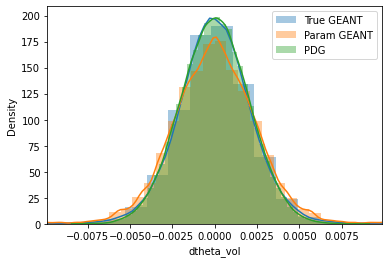

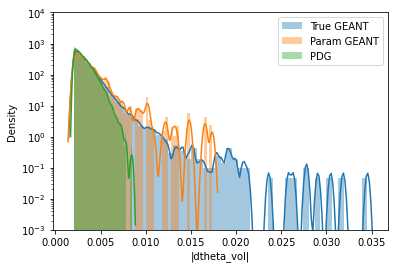

+-------------+---------------------+----------------+------------------------+------------------------+------------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p          |      bulk95_ks_p       |      bulk68_ks_p       |
+-------------+---------------------+----------------+------------------------+------------------------+------------------------+
|     pdg     |  tensor(5.1218e-06) | tensor(0.1011) | 0.0001340163656329796  |  0.04771481699960212   |  0.06505487269451216   |
| param_geant | tensor(-1.8803e-05) | tensor(0.1636) | 1.2887509573056442e-72 | 2.5385473708259127e-43 | 2.0987643954558853e-07 |
+-------------+---------------------+----------------+------------------------+------------------------+------------------------+


 dphi_vol


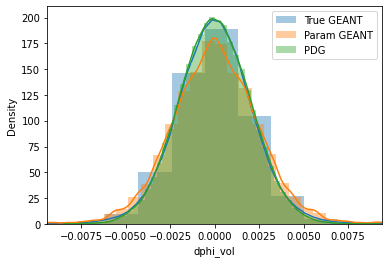

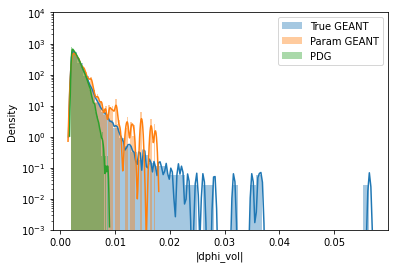

+-------------+---------------------+----------------+-----------------------+-----------------------+-----------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p      |      bulk68_ks_p      |
+-------------+---------------------+----------------+-----------------------+-----------------------+-----------------------+
|     pdg     | tensor(-7.6030e-06) | tensor(0.0945) | 0.0019278065545600192 |  0.03789592280429399  |   0.6093815957192268  |
| param_geant |  tensor(1.5263e-05) | tensor(0.1766) | 8.052134738739928e-71 | 1.761230862917541e-37 | 1.320717832404663e-07 |
+-------------+---------------------+----------------+-----------------------+-----------------------+-----------------------+


 dspace_vol


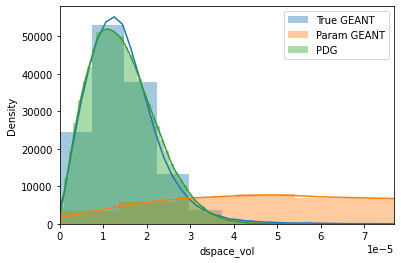

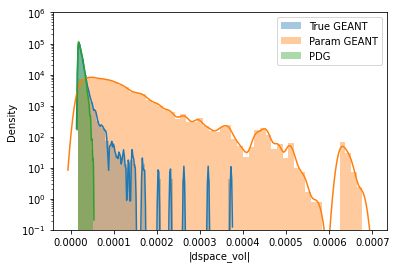

+-------------+----------------+----------------+------------------------+------------------------+------------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p          |      bulk95_ks_p       |      bulk68_ks_p       |
+-------------+----------------+----------------+------------------------+------------------------+------------------------+
|     pdg     | tensor(0.0071) | tensor(0.1357) | 3.7790278400266555e-21 | 7.4322568302805415e-31 | 8.202201405841909e-14  |
| param_geant | tensor(5.5312) | tensor(7.8109) |          0.0           |          0.0           | 2.0536964222199446e-66 |
+-------------+----------------+----------------+------------------------+------------------------+------------------------+


 dx_vol


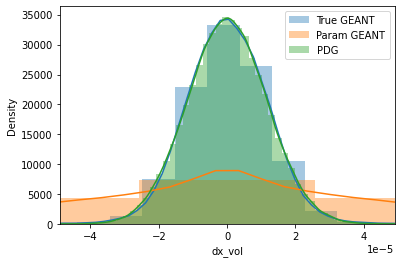

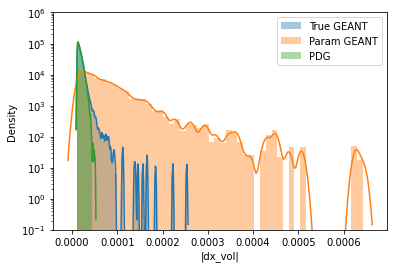

+-------------+---------------------+----------------+---------------------+-------------------------+-------------------------+
|     Sim     |         mean        |   std_fdiff    |         ks_p        |       bulk95_ks_p       |       bulk68_ks_p       |
+-------------+---------------------+----------------+---------------------+-------------------------+-------------------------+
|     pdg     |  tensor(1.1745e-08) | tensor(0.0399) | 0.07644876547856005 |   0.053104722553597994  |   0.37619299878599755   |
| param_geant | tensor(-1.4611e-07) | tensor(6.2068) |         0.0         | 1.7428923875140206e-160 | 1.7478711179329456e-262 |
+-------------+---------------------+----------------+---------------------+-------------------------+-------------------------+


 dy_vol


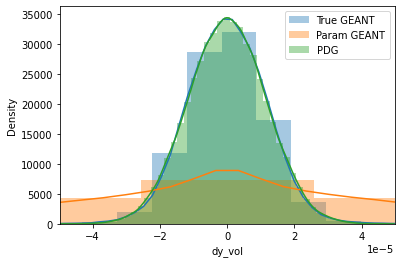

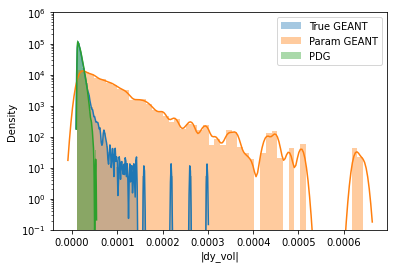

+-------------+---------------------+----------------+---------------------+------------------------+------------------------+
|     Sim     |         mean        |   std_fdiff    |         ks_p        |      bulk95_ks_p       |      bulk68_ks_p       |
+-------------+---------------------+----------------+---------------------+------------------------+------------------------+
|     pdg     | tensor(-2.8215e-08) | tensor(0.0392) | 0.06733861338421354 |  0.09716715382537122   |   0.878056356357545    |
| param_geant |  tensor(4.7519e-07) | tensor(6.2070) |         0.0         | 6.574792576558162e-155 | 1.522284561535323e-262 |
+-------------+---------------------+----------------+---------------------+------------------------+------------------------+


In [11]:
results = get_scatters(val_data[4], n_ks_samples=None)

Making sims for mat='iron', dz=0.01, mom=50.0, theta=0.0, phi=0, n_muons=100000


 dangle_vol


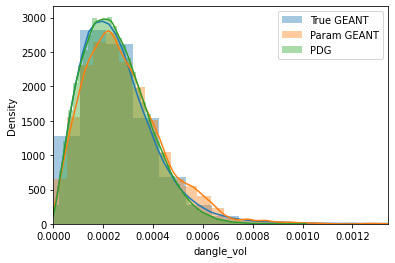

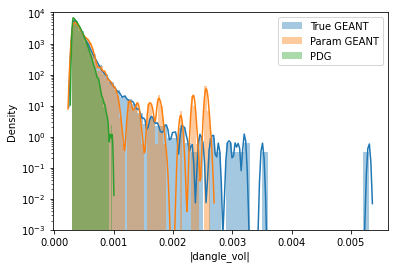

+-------------+----------------+----------------+------------------------+------------------------+------------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p          |      bulk95_ks_p       |      bulk68_ks_p       |
+-------------+----------------+----------------+------------------------+------------------------+------------------------+
|     pdg     | tensor(0.0361) | tensor(0.1888) | 5.148127170422101e-25  | 2.2063628164426307e-14 | 0.00027809695904418714 |
| param_geant | tensor(0.0916) | tensor(0.1583) | 8.327339073887229e-162 | 1.1812739376592005e-95 | 5.532109800654296e-25  |
+-------------+----------------+----------------+------------------------+------------------------+------------------------+


 dtheta_vol


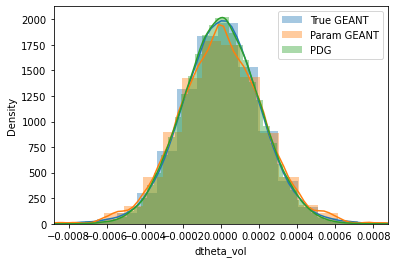

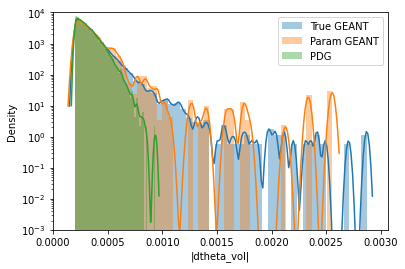

+-------------+--------------------+----------------+-----------------------+------------------------+------------------------+
|     Sim     |        mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p       |      bulk68_ks_p       |
+-------------+--------------------+----------------+-----------------------+------------------------+------------------------+
|     pdg     | tensor(7.0714e-07) | tensor(0.0768) |  0.005133887968153421 |  0.32078043210375573   |   0.2941999982919753   |
| param_geant | tensor(3.7617e-07) | tensor(0.1202) | 7.712929685846054e-18 | 2.3786561746795186e-11 | 0.00013245591637203545 |
+-------------+--------------------+----------------+-----------------------+------------------------+------------------------+


 dphi_vol


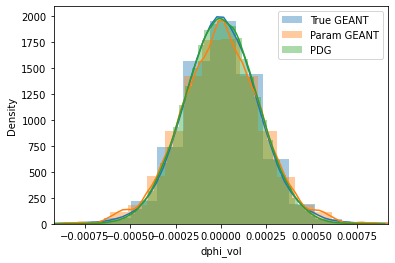

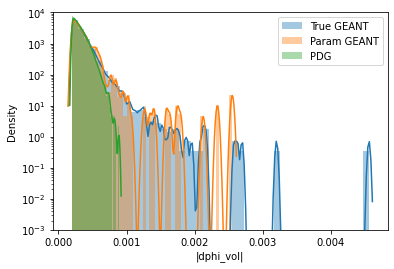

+-------------+---------------------+----------------+----------------------+------------------------+----------------------+
|     Sim     |         mean        |   std_fdiff    |         ks_p         |      bulk95_ks_p       |     bulk68_ks_p      |
+-------------+---------------------+----------------+----------------------+------------------------+----------------------+
|     pdg     |  tensor(7.7768e-07) | tensor(0.0757) | 0.006860265441199353 |   0.022232154954417    | 0.07715054385919407  |
| param_geant | tensor(-2.6829e-07) | tensor(0.1012) | 2.28615413749012e-19 | 1.2973871853782217e-13 | 0.000335495241132385 |
+-------------+---------------------+----------------+----------------------+------------------------+----------------------+


 dspace_vol


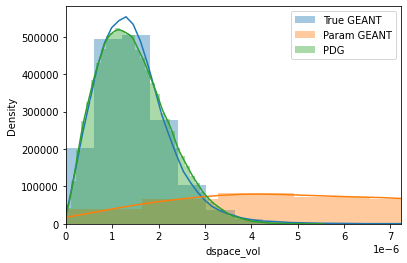

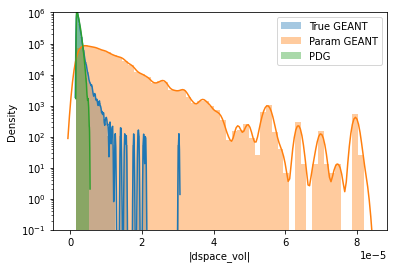

+-------------+----------------+----------------+-----------------------+-----------------------+------------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p         |      bulk95_ks_p      |      bulk68_ks_p       |
+-------------+----------------+----------------+-----------------------+-----------------------+------------------------+
|     pdg     | tensor(0.0012) | tensor(0.0948) | 6.527222053645481e-26 | 1.649148733531911e-30 | 2.692785408443179e-13  |
| param_geant | tensor(5.4904) | tensor(8.3250) |          0.0          |          0.0          | 1.2063788203022327e-53 |
+-------------+----------------+----------------+-----------------------+-----------------------+------------------------+


 dx_vol


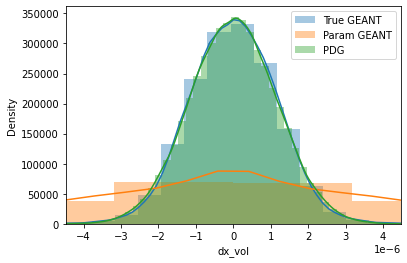

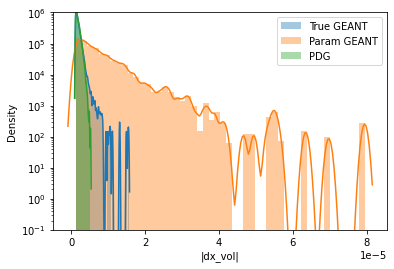

+-------------+---------------------+----------------+---------------------+------------------------+------------------------+
|     Sim     |         mean        |   std_fdiff    |         ks_p        |      bulk95_ks_p       |      bulk68_ks_p       |
+-------------+---------------------+----------------+---------------------+------------------------+------------------------+
|     pdg     | tensor(-2.7813e-09) | tensor(0.0198) | 0.03858453452507504 |  0.11121558622315064   |  0.029661510827586723  |
| param_geant | tensor(-1.0352e-08) | tensor(6.2658) |         0.0         | 1.604889010393397e-170 | 4.729262699071255e-275 |
+-------------+---------------------+----------------+---------------------+------------------------+------------------------+


 dy_vol


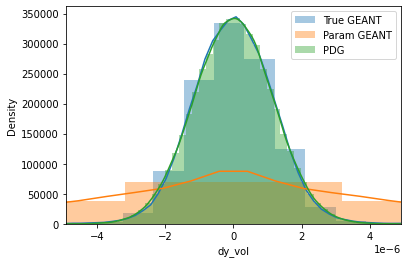

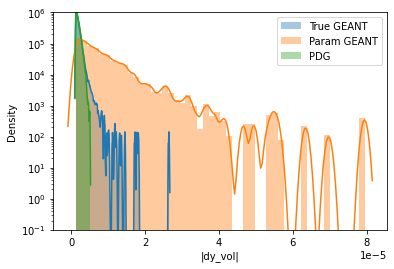

+-------------+--------------------+----------------+---------------------+-------------------------+-------------------------+
|     Sim     |        mean        |   std_fdiff    |         ks_p        |       bulk95_ks_p       |       bulk68_ks_p       |
+-------------+--------------------+----------------+---------------------+-------------------------+-------------------------+
|     pdg     | tensor(1.3281e-09) | tensor(0.0276) | 0.07910729476714418 |    0.2693414692559536   |   0.33457124667490357   |
| param_geant | tensor(2.0102e-08) | tensor(6.3381) |         0.0         | 2.1123931127300813e-151 | 1.4755850908004123e-265 |
+-------------+--------------------+----------------+---------------------+-------------------------+-------------------------+


In [12]:
results = get_scatters(val_data[1], n_ks_samples=None)

Making sims for mat='iron', dz=0.01, mom=5.0, theta=0.7853981633974483, phi=0, n_muons=100000


 dangle_vol


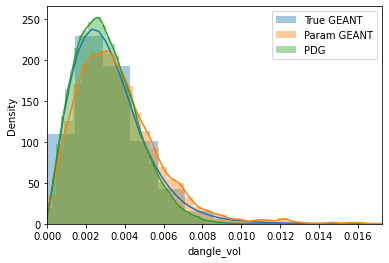

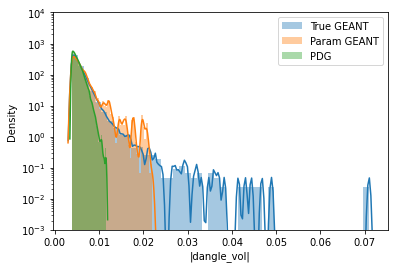

+-------------+----------------+----------------+------------------------+-------------------------+-----------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p          |       bulk95_ks_p       |      bulk68_ks_p      |
+-------------+----------------+----------------+------------------------+-------------------------+-----------------------+
|     pdg     | tensor(0.0673) | tensor(0.2299) | 5.777133272215203e-65  |  9.259916335011851e-07  | 0.0028501233567748484 |
| param_geant | tensor(0.1300) | tensor(0.1398) | 4.668022564927439e-296 | 1.8383624008869385e-197 |  1.69902722662003e-40 |
+-------------+----------------+----------------+------------------------+-------------------------+-----------------------+


 dtheta_vol


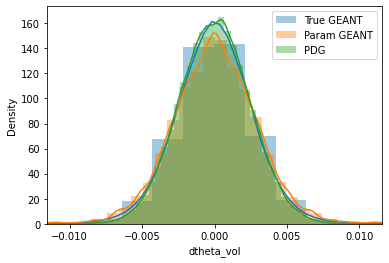

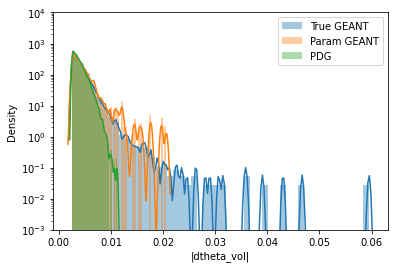

+-------------+---------------------+----------------+-----------------------+------------------------+-----------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p       |      bulk68_ks_p      |
+-------------+---------------------+----------------+-----------------------+------------------------+-----------------------+
|     pdg     | tensor(-8.5561e-07) | tensor(0.1081) | 6.983260317251818e-08 |   0.5034056748603948   |  0.09858793900450169  |
| param_geant |  tensor(9.3987e-06) | tensor(0.1330) | 3.316464392399681e-42 | 1.2639319414492754e-23 | 0.0005306302848357246 |
+-------------+---------------------+----------------+-----------------------+------------------------+-----------------------+


 dphi_vol


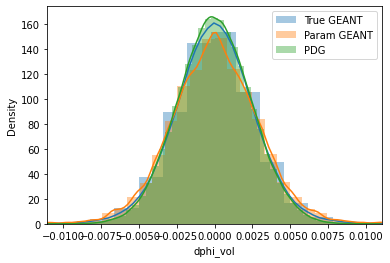

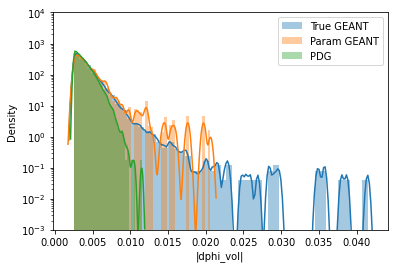

+-------------+---------------------+----------------+-----------------------+------------------------+-----------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p       |      bulk68_ks_p      |
+-------------+---------------------+----------------+-----------------------+------------------------+-----------------------+
|     pdg     | tensor(-7.0831e-06) | tensor(0.1131) | 6.124046655569708e-08 |   0.1452131271432573   |  0.22842400378826877  |
| param_geant |  tensor(8.8844e-06) | tensor(0.1326) | 2.547681113961754e-35 | 1.1492231254934647e-20 | 9.727587057728959e-05 |
+-------------+---------------------+----------------+-----------------------+------------------------+-----------------------+


 dspace_vol


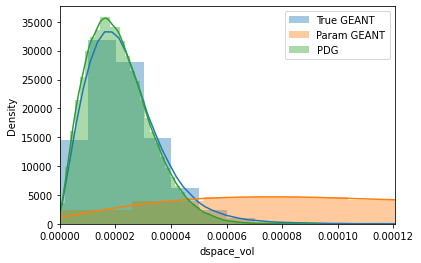

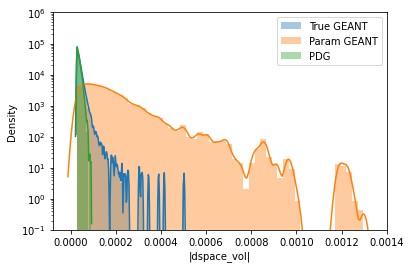

+-------------+----------------+----------------+-----------------------+----------------------+------------------------+
|     Sim     |   mean_fdiff   |   std_fdiff    |          ks_p         |     bulk95_ks_p      |      bulk68_ks_p       |
+-------------+----------------+----------------+-----------------------+----------------------+------------------------+
|     pdg     | tensor(0.0908) | tensor(0.2089) | 4.455452933812951e-95 | 5.74283943078406e-44 | 5.585901803381925e-16  |
| param_geant | tensor(5.6276) | tensor(7.8802) |          0.0          |         0.0          | 1.0323429808616341e-49 |
+-------------+----------------+----------------+-----------------------+----------------------+------------------------+


 dx_vol


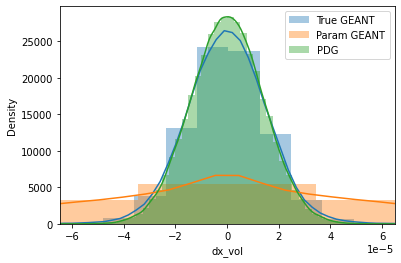

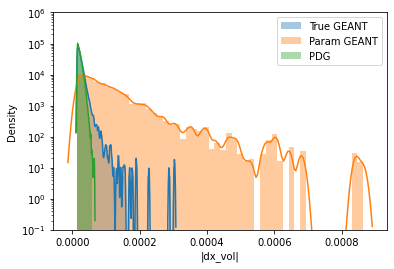

+-------------+---------------------+----------------+-----------------------+-------------------------+-------------------------+
|     Sim     |         mean        |   std_fdiff    |          ks_p         |       bulk95_ks_p       |       bulk68_ks_p       |
+-------------+---------------------+----------------+-----------------------+-------------------------+-------------------------+
|     pdg     | tensor(-2.2088e-10) | tensor(0.1270) | 3.348793049708969e-17 |  2.0960720102172676e-07 |   0.02539853244540502   |
| param_geant |  tensor(1.5461e-07) | tensor(6.2784) |          0.0          | 1.3426044776257887e-161 | 2.3108643340557293e-277 |
+-------------+---------------------+----------------+-----------------------+-------------------------+-------------------------+


 dy_vol


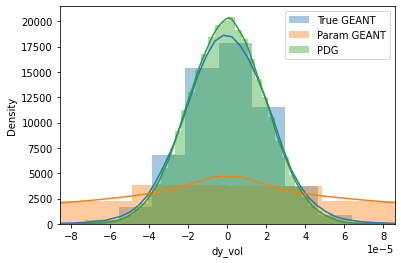

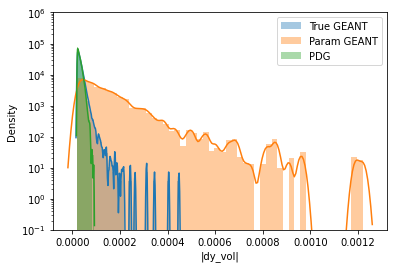

+-------------+---------------------+----------------+----------------------+-------------------------+-------------------------+
|     Sim     |         mean        |   std_fdiff    |         ks_p         |       bulk95_ks_p       |       bulk68_ks_p       |
+-------------+---------------------+----------------+----------------------+-------------------------+-------------------------+
|     pdg     | tensor(-3.6140e-08) | tensor(0.1197) | 7.61230347720695e-17 |  1.0988215748254201e-07 |   0.02893886622337949   |
| param_geant | tensor(-1.3026e-07) | tensor(6.3488) |         0.0          | 2.3987317823570933e-165 | 3.1310031820658725e-279 |
+-------------+---------------------+----------------+----------------------+-------------------------+-------------------------+


In [13]:
results = get_scatters(val_data[0], n_ks_samples=None)